# Biorector Model
Bioreactor mode that models the concentration of NPEC (non-pathogenic E. coli) that produces GFP (green fluorescent protein) in a bioreactor. It also models the concentration of oxygen and the mass transfer rate. The mass transfer rate increases with agitation and flow rate of air into the bioreactor.

In [1]:
#import needed packages
import numpy as np
import matplotlib.pyplot as plt
#import ode solver from scipy.integrate
from scipy.integrate import odeint

## Understand the Logistic-Monod Growth Model

The logistic portion of the growth model models the limits of growth due to the carrying capacity of the bioreactor. The Monod portion models the growth rate as a function of the substrate concentration. The logistic-Monod growth model can be expressed as (Monod portion first and the logistic portion second):

\begin{equation}
\frac{1}{X}\frac{dX}{dt} = \left[ \mu_a + \frac{\mu_{m}S}{K_s + S} \right] \left[ 1-\frac{X}{X_m} \right]
\end{equation}

where $\mu_a$ is the NPEC growth rate without substrate (oxygen), $\mu_m$ is the maximum specific growth rate of NPEC with substrate (oxygen), $K_s$ is the Monod constant for substrate (oxygen), $S$ is the substrate (oxygen) concentration, $X$ is the NPEC concentration, and $X_m$ is the carrying capacity of the bioreactor.

## Understand transfer and consumption of the substrate (oxygen)

The substrate (oxygen) concentration changes as a function of time based on the number of NPEC cells and the mass transfer rate. The mass transfer rate is a simplification of what really happens as the rate increases with agitation and flow rate of air into the bioreactor. The change in substrate (oxygen) concentration can be expressed as:

\begin{equation}
\frac{dS}{dt} = -X\cdot b + k_{La}(C - S)
\end{equation}

where $X$ is the NPEC concentration, $b$ is the consumption rate of substrate by the NPEC, $C$ is the max oxygen concentration possible, and $k_{La}$ is the mass transfer coefficient.

## Understand the $k_{La}$ parameter
The $k_{La}$ is the mass transfer coefficient that increases with agitation and flow rate of air into the bioreactor. However, instead of modeling agitation and flow rate directly, we'll just use a proportional and integral (PI) controller to model the changing $k_{La}$. An increasing $k_{La}$ means that more oxygen can be transferred (dissolved) into the fluid. That PI control is:

\begin{equation}
\frac{dk_{La}}{dt} = -K_p \frac{dS}{dt} + K_i(D_o - S)
\end{equation}

where $K_p$ is the proportional gain and $K_i$ is the integral gain. The $D_o$ is the desired oxygen concentration (set point). This equation is just the derivative of the PI control equation.

With proportional control and the value of S above the setpoint, the controller sees the rate of oxygen drop and tries to anticipate the loss by increasing $k_{La}$ immediately, even though you are currently above the setpoint. This results in a positive change in $k_{La}$ which is unexpected. For bioreactors with noisy consumption rates or when you want the controller to respond strictly to the level of oxygen (not the rate of change), an Integral-only controller (or a very heavily detuned PI) is often preferred.

Without feed forward control with purely integral control, it can take a while for the integral term to "wind up". Feed forward helps with that to calculate how much the oxygen will be needed and adjust kla immediately.

### Feed forward control

Rate of consumption by the cells equaling the rate of transfer is:

\begin{equation}
k_{La} = \frac{bX}{(C-S)}
\end{equation}

And assuming that the controller does its job then S can be replaced with $D_o$ to get:

\begin{equation}
k_{La} = \frac{bX}{(C-D_o)}
\end{equation}

and the derivative of this equation is:
\begin{equation}
\frac{dk_{La}}{dt} = \frac{b}{C-D_o}
\end{equation}

## Typical Parameter Values

| Parameter | Value | Unit | Note |
| --- | --- | --- | --- |
| $X_m$ | 5E9 | CFU/mL | Carrying capacity of the bioreactor, could be cast such that this is 1 |
| $\mu_a$ | 0.3 | $\text{hr}^{-1}$ | NPEC growth rate without substrate |
| $\mu_m$ | 1.4 | $\text{hr}^{-1}$ | Maximum specific growth rate of NPEC with substrate |
| $K_s$ | 5 | mg/L | Monod constant for substrate (oxygen), could be cast so this is a fraction of the max oxygen concentration |
| $b$ | 0.01 | $\text{hr}^{-1}$ | Consumption rate of substrate by NPEC |
| $C$ | 6 | mg/L | Max oxygen concentration possible in broth, could be cast such that this is 1 |
| $k_{La}$ | 20 | $\text{hr}^{-1}$ | Typical max mass transfer coefficient for a pipe with gas exit with agitation|
| $K_i$ | 110 | $\text{hr}^{-1}$ | Integral gain |

## Setup Coupled Differential Equations
Setup the coupled differential equations for the bioreactor model that includes tracking the NPEC concentration $X$, the oxygen or substrate concentration $S$, and the $k_{L a}$ value. 

In [2]:
def derivatives(y, t, p):
    # Unpack the state vector and parameters
    X, S, kla = y; mua, mum, Ks, Xm, b, C, Kp, Ki, Do = p
    # Compute the derivatives
    # First the Logistic - Monod Equation
    dXdt = (mua + (mum * S)/(Ks + S))*(1-X/Xm)*X
    # Then the substrate depletion with bounds on X not to go below 0
    if S < 0:
        dSdt = 0
    else:
        dSdt = -X*b + kla*(C - S)
    # Finally the kla change with bounds not to go below 0 or above 20
    if kla < 0: # or kla > 20:
        dkladt_PI = 0
    else:  
        #dkladt = -Kp*dSdt + Ki*(Do - S) see comment below why only integral control is used
        dkladt_PI = Ki*(Do - S)


    # B. The Feed-Forward part
    # Derivative of the FF law: (b / (C - Do)) * dXdt, This proactively ramps up kla as the cells grow
    if (C - Do) > 0: # Avoid division by zero
        dkladt_FF = (b / (C - Do)) * dXdt
    else:
        dkladt_FF = 0
        
    # Combine them
    if kla > 20:
        dkladt = 0
    else:
        dkladt = dkladt_PI + dkladt_FF

    return [dXdt, dSdt, dkladt]

### Set the parameter values and initial conditions


In [3]:
# parameter values
mua = 0.1 #1/hr
mum = 1.4 #1/hr
C = 1 #change to fraction of possible dissolved oxygen 6 # mg/L
Ks = 5/6 # change to fraction of C rather than a concentration 5 # mg/L
Xm = 1 #5e9 # cells/mL
b = 100 #1/hr
Kp = 0.2
Ki = 110 #1/hr
#disolved oxygen set point
Do = 0.96
p = [mua, mum, Ks, Xm, b, C, Kp, Ki, Do]

# Initial condition
X0 = 1e7/5e9 #changed to X/Xm initial was # cells/mL
S0 = 0.8 #Changed to fraction saturation was # mg/L
kla0 = 0.2 #1/hr
y0 = [X0, S0, kla0]

### Solve the differential equations

In [4]:
# set time span for the simulation
t = np.linspace(0, 10, 50000) # 10 hours
vals = np.zeros((len(t), 3))
vals[0, :] = y0
errInt = 0
for i in range(1, len(t)):
    # Compute the derivatives at the current time step
    dXdt, dSdt, dkladt = derivatives(vals[i-1, :], t[i-1], p)
    #print("dXdt: ", dXdt, "dSdt: ", dSdt, "dkladt: ", dkladt)
    #print("S:", vals[i-1, 1], "X: ", vals[i-1, 0])
    # Update the state vector using the Euler method
    vals[i, 0] = vals[i-1, 0] + dXdt * (t[i] - t[i-1])
    vals[i, 1] = vals[i-1, 1] + dSdt * (t[i] - t[i-1])
    vals[i, 2] = vals[i-1, 2] + dkladt * (t[i] - t[i-1])

### Plot the results

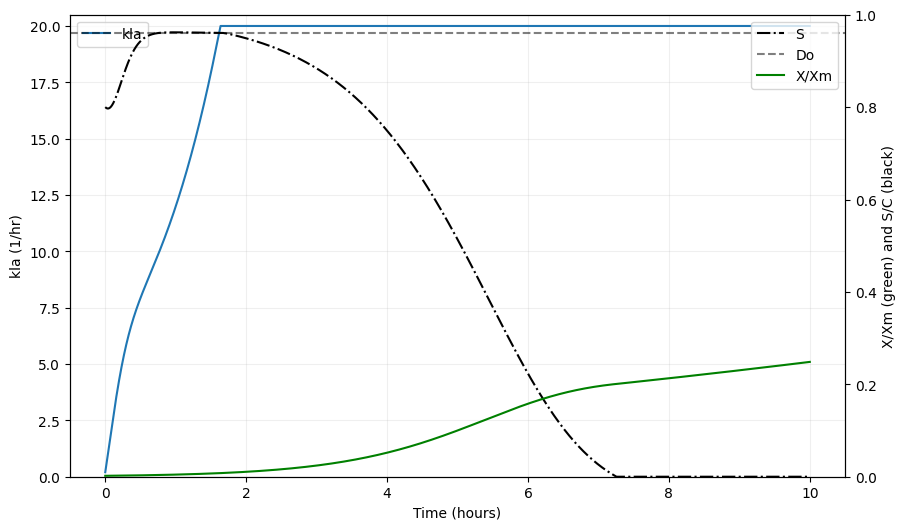

In [5]:
#plot results
plt.figure(figsize=(10, 6))
#add primary y-axis for X and S
ax1 = plt.gca()
ax1.plot(t, vals[:, 2], label='kla')
#plot Do
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('kla (1/hr)')
ax1.grid(alpha=0.2)
ax1.set_ylim([0, 20.5])
#add secondary y-axis for kla
ax2 = plt.gca().twinx()
ax2.plot(t, vals[:, 1], label='S', color='k', linestyle='-.')
ax2.axhline(y=Do, color='k', linestyle='--', label='Do', alpha=0.5)
ax2.plot(t, vals[:, 0], label='X/Xm', color='g')
ax2.set_ylabel('X/Xm (green) and S/C (black)')
plt.xlabel('Time (hours)')
ax2.set_ylim([0, 1])
#add legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()